# Notebook 1: Cargar o conxunto de datos en MySQL

Datos cargados en la tabla 'Netflix' correctamente.
Número de filas cargadas: 8807
('s1', 'Movie', 'Dick Johnson Is Dead', 'Kirsten Johnson', None, 'United States', 'September 25, 2021', 2020, 'PG-13', '90 min', 'Documentaries', 'As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.')
('s2', 'TV Show', 'Blood & Water', None, 'Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mah ... (5 characters truncated) ... , Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng', 'South Africa', 'September 24, 2021', 2021, 'TV-MA', '2 Seasons', 'International TV Shows, TV Dramas, TV Mysteries', 'After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister

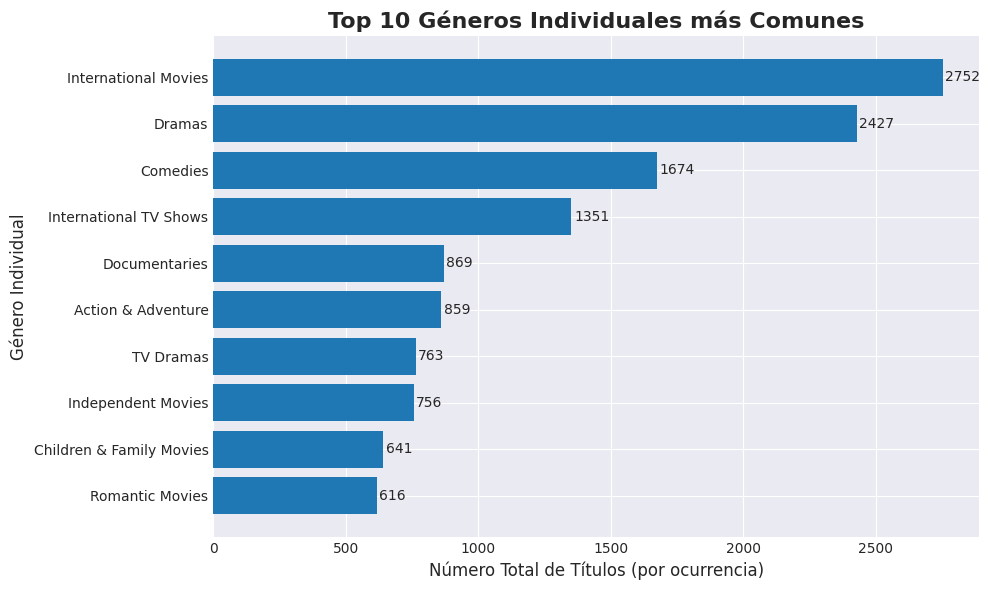

In [1]:

import pandas as pd
from sqlalchemy import create_engine, text 
mysql_user = "user"
mysql_password = "password"
mysql_host = "127.0.0.1"
mysql_port = "3306"
mysql_db = "testdb"
engine = create_engine(f"mysql+mysqlconnector://{mysql_user}:{mysql_password}@{mysql_host}:{mysql_port}/{mysql_db}") 

df = pd.read_csv("../data/netflix_titles.csv") 
tabla_nombre = "Netflix" 
df.to_sql(name=tabla_nombre, con=engine, if_exists='replace', index=False)

print(f"Datos cargados en la tabla '{tabla_nombre}' correctamente.") 

with engine.connect() as conn:
    result = conn.execute(text(f"SELECT COUNT(*) FROM {tabla_nombre};"))
    count = result.scalar()
    print(f"Número de filas cargadas: {count}")

    result = conn.execute(text(f"SELECT * FROM {tabla_nombre} LIMIT 5;"))
    for row in result:
        print(row)

    pais = "Spain"
    result = conn.execute(text(f"""
                SELECT title, country
                FROM {tabla_nombre}
                WHERE country = :pais
                LIMIT 10;
            """), {"pais": pais})
    for row in result:
        print(row)

    query_todos_generos = text(f"""
             SELECT listed_in
             FROM {tabla_nombre};
        """)

    result = conn.execute(query_todos_generos)
    df_raw_generos = pd.DataFrame(result.fetchall(), columns=result.keys()) 
    df_split = df_raw_generos['listed_in'].str.split(', ', expand=True).stack()
    df_split = df_split.str.strip()

    conteo_generos = df_split.value_counts().head(10)

    df_generos_individuales = conteo_generos.reset_index()
    df_generos_individuales.columns = ['genero', 'total']

    print ("\n Top 10 Géneros Individuales más comunes son: ")
    print(df_generos_individuales)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(df_generos_individuales['genero'], df_generos_individuales['total'])

ax.set_title('Top 10 Géneros Individuales más Comunes', fontsize=16, fontweight='bold')
ax.set_xlabel('Número Total de Títulos (por ocurrencia)', fontsize=12)
ax.set_ylabel('Género Individual', fontsize=12)

ax.invert_yaxis() 
for i, (total, genero) in enumerate(zip(df_generos_individuales['total'], df_generos_individuales['genero'])):
    ax.text(total + 10, i, str(total), va='center')

plt.tight_layout()
plt.show()


# Notebook 2: Consultar datos desde MySQL e cargalos en Cassandra.

In [2]:
# CONEXIÓN A MYSQL
mysql_user = "user"
mysql_password = "password"
mysql_host = "127.0.0.1"
mysql_port = "3306"
mysql_db = "testdb"
table_name = "mi_tabla"

engine = create_engine(f"mysql+mysqlconnector://{mysql_user}:{mysql_password}@{mysql_host}:{mysql_port}/{mysql_db}")

# GUARDAMOS LOS DATOS SACADOS DE LA TABLA DE MYSQL EN UN DATAFRAME DE PANDAS
df = pd.read_sql(f"SELECT * FROM {table_name}", engine)

In [3]:
from cassandra.cluster import Cluster

# CONEXIÓN AL CLUSTER DE CASSANDRA
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

# CREACIÓN DEL KEYSPACE SI NO EXISTE
session.execute("""
CREATE KEYSPACE IF NOT EXISTS netflix_keyspace
WITH REPLICATION = { 'class': 'SimpleStrategy', 'replication_factor': 1 }
""")

# SE SELECCIONA LA KEYSPACE
session.set_keyspace('netflix_keyspace')

# CREAR LA TABLA SI NO EXISTE
session.execute("""
CREATE TABLE IF NOT EXISTS netflix_table (
    show_id TEXT PRIMARY KEY,
    type TEXT,
    title TEXT,
    director TEXT,
    cast TEXT,
    country TEXT,
    date_added TEXT,
    release_year INT,
    rating TEXT,
    duration TEXT,
    listed_in TEXT,
    description TEXT
)
""")

In [4]:
from cassandra.query import PreparedStatement

# PREPARACIÓN DE LA QUERY PARA INSERTAR LOS DATOS ALMACENADOS EN EL DATAFRAME SACADO DE MYSQL. SE APLICAN 
# LOS INTERROGANTES PARA PASARLE LA INFORMACIÓN ALMACENADA EN EL DATAFRAME.
insert_query = session.prepare("""
INSERT INTO netflix_table (
    show_id, type, title, director, cast, country,
    date_added, release_year, rating, duration,
    listed_in, description
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""")

# SE LE AÑADEN LOS DATOS A LA QUERY HACIENDO UNA ITERACIÓN POR FILA DEL DATASET.
for _, row in df.iterrows():
    session.execute(insert_query, (
        row['show_id'], row['type'], row['title'], row['director'],
        row['cast'], row['country'], row['date_added'], row['release_year'],
        row['rating'], row['duration'], row['listed_in'], row['description']
    ))

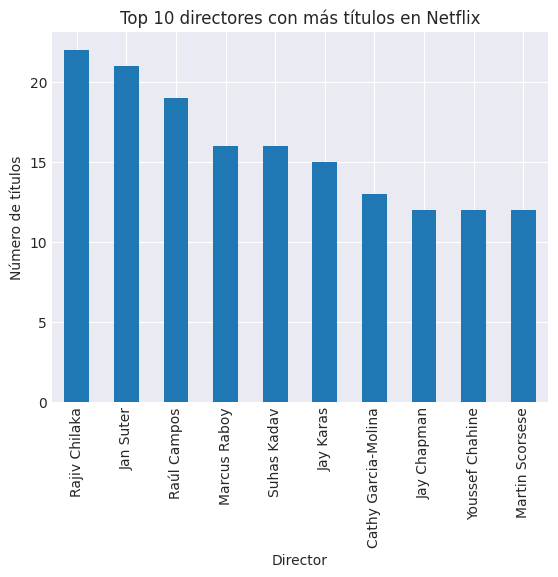

In [5]:
import matplotlib.pyplot as plt

# SE GUARDAN LOS DATOS DE LA TABLA EN UN DATAFRAME DE PANDAS PARA CONSULTARLOS MEJOR.
query = "SELECT * FROM netflix_table"
rows = session.execute(query)
netflix_cassandra = pd.DataFrame(rows)

# SE FILTRAN LOS DIRECTORES Y LUEGO SE GUARDAN LOS 10 QUE MÁS TÍTULOS TIENEN.
directores = netflix_cassandra['director'].dropna().str.split(',').explode().str.strip()
top_directores = directores.value_counts().head(10)

# GRÁFICA PARA MOSTRAR LOS DIRECTORES GUARDADOS EN UN GRÁFICO DE BARRAS.
top_directores.plot(kind='bar')
plt.title("Top 10 directores con más títulos en Netflix")
plt.xlabel("Director")
plt.ylabel("Número de títulos")
plt.show()

In [6]:
# ¡¡IMPORTANTE CERRAR EL CLUSTER DESPUÉS DE TRABAJAR CON ÉL!!
cluster.shutdown()

# Notebook 3: Consultar datos seleccionados de Cassandra e cargalos en Redis

In [7]:
from cassandra.cluster import Cluster
import redis

### CONECTAR A CASSANDRA

In [12]:
cluster = Cluster(['127.0.0.1'], port=9042)   # Cambia por tu IP
session = cluster.connect('netflix_keyspace')  # Tu keyspace 

### CONECTAR A REDIS

In [15]:
query = "SELECT show_id, description FROM netflix_table;"   # Cambia por tus columnas
rows = session.execute(query)

In [16]:
r = redis.Redis(host='127.0.0.1', port=6379, db=0)

### GUARDAR CADA PAR CHAVE-VALOR EN REDIS

In [18]:
for row in rows:
    key = str(row.show_id)         # clave
    value = row.description        # valor
    r.set(key, value)
    print(f"Guardado en Redis → {key}: {value}")

Guardado en Redis → s419: A faulty transportation machine lands Chhota Bheem and his friends in Russia, where they must save a princess from an evil, power-hungry magician.
Guardado en Redis → s2571: When a rebellious teen searches for her unknown roots, it leads her to the sport of dirt track racing and a discovery she didn't expect.
Guardado en Redis → s8478: A look at the life of karate master Fumio Demura shows how he spread the discipline in the West, winning countless devotees and influencing Hollywood.
Guardado en Redis → s341: A troubled thief who extracts secrets from people's dreams takes one last job: leading a dangerous mission to plant an idea in a target's subconscious.
Guardado en Redis → s3520: Ikoma and the Iron Fortress take their fight to the battlegrounds of Unato, joining the alliance to reclaim the region from the kabane horde.
Guardado en Redis → s6711: God summons narcissistic Evan to build an ark in preparation for a flood. Meanwhile, Evan's family interprets h

### VERIFICAR DATOS EN REDIS

In [19]:
print("\nVerificación en Redis:")
for test_key in r.keys():
    print(test_key.decode(), "→", r.get(test_key).decode())


Verificación en Redis:
s5220 → A little girl discovers she’s the modern-day descendant of Snow White when seven dwarfs arrive at her suburban home to serve as her guardian angels.
s2656 → While researching corruption for his new book, a successful crime novelist shades the line between fiction and reality.
s563 → A swingin' fashion photographer by day and a groovy British secret agent by night, superspy Austin Powers must foil the sinister schemes of Dr. Evil.
s8753 → After surviving a life-threatening accident, a troubled cop finds new purpose when he bonds with a terminally ill little boy. Based on a true story.
s4582 → A disillusioned rickshaw driver in Punjab dreams of moving to Dubai, but his plan to butter up his would-be benefactor goes horribly wrong.
s6006 → Explore the circumstances surrounding the tragic deaths at 27 of Jimi Hendrix, Jim Morrison, Brian Jones, Janis Joplin, Kurt Cobain and Amy Winehouse.
s3726 → A highly decorated ex-Marine sniper returns to action to foil 

# Notebook 4: Consultar datos de MySQL e cargalos en MongoDB

In [20]:
engine = create_engine(f"mysql+mysqlconnector://{mysql_user}:{mysql_password}@{mysql_host}:{mysql_port}/{mysql_db}")
df = pd.read_sql(text("SELECT * FROM mi_tabla"), con=engine)

In [21]:
table_name = "mi_tabla"

In [22]:
with engine.connect() as conn:
    # Contar filas
    result = conn.execute(text(f"SELECT COUNT(*) FROM {table_name};"))
    count = result.scalar()
    print(f"Número de filas cargadas: {count}")

    # Mostrar as primeiras 5 filas
    result = conn.execute(text(f"SELECT * FROM {table_name} LIMIT 5;"))
    for row in result:
        print(row)

Número de filas cargadas: 8807
('s1', 'Movie', 'Dick Johnson Is Dead', 'Kirsten Johnson', None, 'United States', 'September 25, 2021', 2020, 'PG-13', '90 min', 'Documentaries', 'As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.')
('s2', 'TV Show', 'Blood & Water', None, 'Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mah ... (5 characters truncated) ... , Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng', 'South Africa', 'September 24, 2021', 2021, 'TV-MA', '2 Seasons', 'International TV Shows, TV Dramas, TV Mysteries', 'After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.')
('s3', 'TV Show', 'Gan

In [24]:
from pymongo import MongoClient

In [25]:
#Crear conexión a MongoDB
mongo_user = "root"
mongo_password = "rootpassword"
mongo_host = "127.0.0.1"
mongo_port = "27017"

In [26]:
mongo_client = MongoClient(f"mongodb://{mongo_user}:{mongo_password}@{mongo_host}:{mongo_port}/")


In [27]:
mongo_dns = mongo_client["testdb"]
mongo_collection = mongo_dns["mi_tabla"]
mongo_collection.insert_many(df.to_dict('records'))


print(mongo_collection.find_one({"show_id": "s2"}))
print("\nNúmero de documentos en la colección:", mongo_collection.count_documents({}))
print("\nPrimeros 5 documentos en la coleccion:")
for doc in mongo_collection.find().limit(5):
    print(doc)

{'_id': ObjectId('692f094fe792ec03e231f825'), 'show_id': 's2', 'type': 'TV Show', 'title': 'Blood & Water', 'director': None, 'cast': 'Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng', 'country': 'South Africa', 'date_added': 'September 24, 2021', 'release_year': 2021, 'rating': 'TV-MA', 'duration': '2 Seasons', 'listed_in': 'International TV Shows, TV Dramas, TV Mysteries', 'description': 'After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.'}

Número de documentos en la colección: 8807

Primeros 5 documentos en la coleccion:
{'_id': ObjectId('692f094fe792ec03e231f824'), 'show_id': 's1', 'type': 'Movie', 'title': 'Dick Johnson Is Dead', 'di

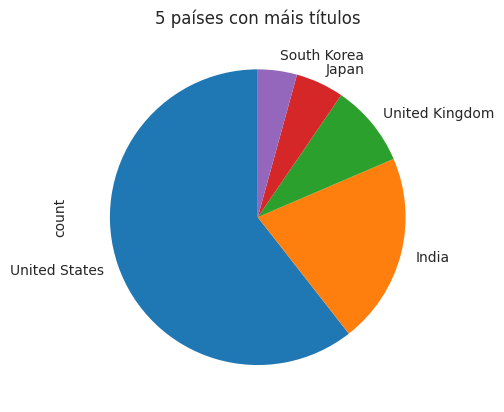

In [28]:
import matplotlib.pyplot as plt

mas_titulos = df['country'].value_counts().head(5)

mas_titulos.plot(kind='pie', startangle=90)
plt.title("5 países con máis títulos")
plt.show()



In [29]:
#Cerrar la conexión
mongo_client.close()